In [5]:
#Import required libraries
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,matthews_corrcoef,confusion_matrix,
     classification_report)


In [14]:
#Import the dataset

train = pd.read_csv(r"MobilePricePrediction/MobilePricePrediction_train.csv")
test = pd.read_csv(r"MobilePricePrediction/MobilePricePrediction_test.csv")

# Separate features and target
X = train.drop("price_range", axis=1)
y = train["price_range"]

# Handle missing values
X = X.fillna(X.mean())
test = test.fillna(test.mean())

# Align train and test columns
X, test = X.align(test, join='left', axis=1, fill_value=0)

print("Final Training Shape:", X.shape)
print("Final Test Shape:", test.shape)


Final Training Shape: (2000, 20)
Final Test Shape: (1000, 20)


In [15]:
#Split Train data and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,stratify=y)

#Feature Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [16]:
# Evaluation function

def evaluate_model(model, X_test, y_test):

    # Convert to numpy explicitly
    y_test = np.array(y_test)

    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred)

    y_prob = model.predict_proba(X_test)

    results = {}

    results["Accuracy"] = accuracy_score(y_test, y_pred)

    # Multi-class AUC
    results["AUC"] = roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')

    results["Precision"] = precision_score (y_test, y_pred, average='weighted')

    results["Recall"] = recall_score(y_test, y_pred, average='weighted')

    results["F1 Score"] = f1_score(y_test, y_pred, average='weighted')

    results["MCC"] = matthews_corrcoef(y_test, y_pred)

    return results

In [17]:
# Machine Learning Classification Models
# 1.Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_scaled, y_train)
lr_results = evaluate_model(lr, X_test_scaled, y_test)

# 2.Decision tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_results = evaluate_model(dt, X_test, y_test)

# 3. K Nearest neighbour
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_scaled, y_train)
knn_results = evaluate_model(knn, X_test_scaled, y_test)

# 4. Naive Bayes Classifier - Gaussian
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_results = evaluate_model(nb, X_test, y_test)

# 5. Ensemble Model - Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_results = evaluate_model(rf, X_test, y_test)

# 6. Ensemble Model - XGBoost
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=4,
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_results = evaluate_model(xgb, X_test, y_test)


In [18]:
# Save Results
results_dict = {
    "Logistic Regression": lr_results,
    "Decision Tree": dt_results,
    "KNN": knn_results,
    "Naive Bayes": nb_results,
    "Random Forest": rf_results,
    "XGBoost": xgb_results
}

In [19]:
results_df = pd.DataFrame(results_dict).T
results_df

,Accuracy,AUC,Precision,Recall,F1 Score,MCC
Logistic Regression,0.9650,0.998667,0.965045,0.9650,0.964986,0.953357
Decision Tree,0.8300,0.886667,0.831883,0.8300,0.830168,0.773811
KNN,0.5325,0.777537,0.556098,0.5325,0.538838,0.378618
Naive Bayes,0.8100,0.950567,0.811326,0.8100,0.810458,0.746804
Random Forest,0.8800,0.976929,0.879614,0.8800,0.879734,0.840049
XGBoost,0.9350,0.994458,0.935487,0.9350,0.934982,0.913501


Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       0.94      0.93      0.93       100
           2       0.87      0.90      0.89       100
           3       0.96      0.91      0.93       100

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.93       400
weighted avg       0.94      0.94      0.93       400



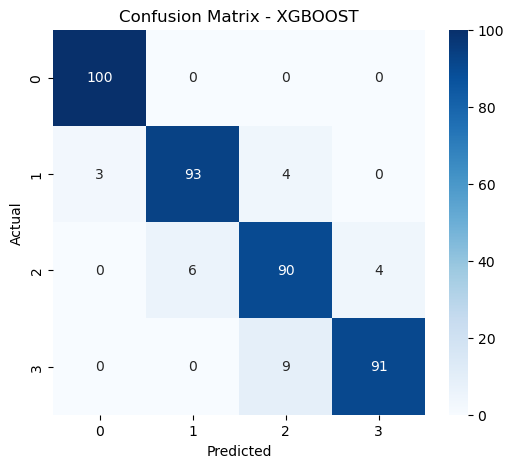

In [20]:
best_model = xgb
y_pred_best = best_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred_best))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBOOST")
plt.show()

In [21]:
import os
import joblib
os.makedirs("model", exist_ok=True)

joblib.dump(lr, "model/logistic.pkl")
joblib.dump(dt, "model/decision_tree.pkl")
joblib.dump(knn, "model/knn.pkl")
joblib.dump(nb, "model/naive_bayes.pkl")
joblib.dump(rf, "model/random_forest.pkl")
joblib.dump(xgb, "model/xgboost.pkl")

print("All models saved successfully!")

All models saved successfully!


In [22]:
#!pip freeze

In [23]:
print(results_df.to_markdown())

|                     |   Accuracy |      AUC |   Precision |   Recall |   F1 Score |      MCC |
|:--------------------|-----------:|---------:|------------:|---------:|-----------:|---------:|
| Logistic Regression |     0.965  | 0.998667 |    0.965045 |   0.965  |   0.964986 | 0.953357 |
| Decision Tree       |     0.83   | 0.886667 |    0.831883 |   0.83   |   0.830168 | 0.773811 |
| KNN                 |     0.5325 | 0.777537 |    0.556098 |   0.5325 |   0.538838 | 0.378618 |
| Naive Bayes         |     0.81   | 0.950567 |    0.811326 |   0.81   |   0.810458 | 0.746804 |
| Random Forest       |     0.88   | 0.976929 |    0.879614 |   0.88   |   0.879734 | 0.840049 |
| XGBoost             |     0.935  | 0.994458 |    0.935487 |   0.935  |   0.934982 | 0.913501 |


In [24]:
#!python --version
#!pip show scikit-learn
#!pip show xgboost
#!pip show numpy
#!pip show pandas
#!pip show matplotlib
#!pip show seaborn
#!pip show joblib
